# The Impact of COVID-19 Lockdowns on the Air Quality of Bangalore.

In [125]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from wwo_hist import retrieve_hist_data
from copy import deepcopy

#### Extracting and loading the datatsets:

In [2]:
with open("data/api_key.txt", "r") as myfile:
        key=myfile.read()

def load_data(key, start_date, end_date, frequency, location):
    
    try:
        df = pd.read_csv('data/bangalore_weather.csv')
        
    except:
        hist_weather_data = retrieve_hist_data(key,
                                        location,
                                        start_date,
                                        end_date,
                                        frequency,
                                        location_label = False,
                                        export_csv = False,
                                        store_df = True)

        for i in hist_weather_data:
            df = pd.DataFrame(i)

        df.to_csv('data/bangalore_weather.csv', index=False)
    
    df_aqi_full = pd.read_csv('data/city_day.csv')
    df_aqi = df_aqi_full[(df_aqi_full['City']=='Bengaluru') & (df_aqi_full.AQI.notnull())].reset_index(drop=True)
    
    return df, df_aqi


df, df_aqi = load_data(key, '01-JAN-2010', '20-SEP-2021', 24, ['Bangalore'])

In [44]:
df.head(3)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2010-01-01,24,17,0.0,7.3,5,100,06:48 PM,07:01 AM,06:42 AM,...,14,79,84,1.0,1014,24,8,99,9,Bangalore
1,2010-01-02,26,17,0.0,11.6,6,85,07:53 PM,07:59 AM,06:42 AM,...,15,27,78,0.0,1015,26,9,76,9,Bangalore
2,2010-01-03,26,16,0.0,11.6,6,77,08:54 PM,08:51 AM,06:42 AM,...,12,41,77,0.0,1015,26,8,52,7,Bangalore


In [45]:
df_aqi.head(3)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Bengaluru,2015-03-21,48.59,NaN,3.47,27.00,18.04,28.02,3.89,1.94,52.96,21.33,196.72,NaN,91.0,Satisfactory
1,Bengaluru,2015-03-22,47.38,NaN,2.84,22.39,15.33,23.19,11.29,2.05,71.85,14.97,138.20,NaN,120.0,Moderate
2,Bengaluru,2015-03-23,65.65,NaN,3.10,26.35,17.45,27.76,9.95,6.30,72.84,9.88,100.77,NaN,154.0,Moderate


#### Exploring our data for trends:

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4281 entries, 0 to 4280
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          4281 non-null   datetime64[ns]
 1   maxtempC           4281 non-null   int64         
 2   mintempC           4281 non-null   int64         
 3   totalSnow_cm       4281 non-null   float64       
 4   sunHour            4281 non-null   float64       
 5   uvIndex            4281 non-null   int64         
 6   moon_illumination  4281 non-null   int64         
 7   moonrise           4281 non-null   object        
 8   moonset            4281 non-null   object        
 9   sunrise            4281 non-null   object        
 10  sunset             4281 non-null   object        
 11  DewPointC          4281 non-null   int64         
 12  FeelsLikeC         4281 non-null   int64         
 13  HeatIndexC         4281 non-null   int64         
 14  WindChil

In [6]:
df['date_time'] = df['date_time'].apply(pd.to_datetime, errors='ignore')
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,4281.000000,4281.000000,4281.0,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000,4281.000000
mean,29.683485,20.232422,0.0,10.729269,6.244803,46.111423,15.894884,25.344546,25.368372,24.513899,18.052091,33.386125,63.782761,4.349708,1010.449895,29.683485,9.317683,177.493576,13.074048
std,3.493790,2.677081,0.0,1.914474,0.965944,31.277615,3.749539,2.914546,2.878460,2.873966,6.416090,23.589800,15.493366,9.801522,2.821542,3.493790,1.077592,81.714205,5.140810
min,19.000000,13.000000,0.0,4.200000,4.000000,0.000000,0.000000,18.000000,19.000000,18.000000,4.000000,0.000000,19.000000,0.000000,1003.000000,19.000000,4.000000,19.000000,3.000000
25%,27.000000,19.000000,0.0,8.900000,6.000000,18.000000,14.000000,23.000000,23.000000,22.000000,13.000000,12.000000,52.000000,0.000000,1008.000000,27.000000,9.000000,99.000000,9.000000
50%,29.000000,20.000000,0.0,11.600000,6.000000,46.000000,17.000000,25.000000,25.000000,24.000000,17.000000,31.000000,67.000000,0.500000,1010.000000,29.000000,10.000000,165.000000,12.000000
75%,32.000000,22.000000,0.0,11.600000,7.000000,73.000000,19.000000,27.000000,27.000000,26.000000,22.000000,51.000000,76.000000,4.100000,1013.000000,32.000000,10.000000,261.000000,16.000000
max,41.000000,29.000000,0.0,12.900000,9.000000,100.000000,22.000000,33.000000,33.000000,33.000000,49.000000,100.000000,98.000000,198.000000,1019.000000,41.000000,10.000000,332.000000,35.000000


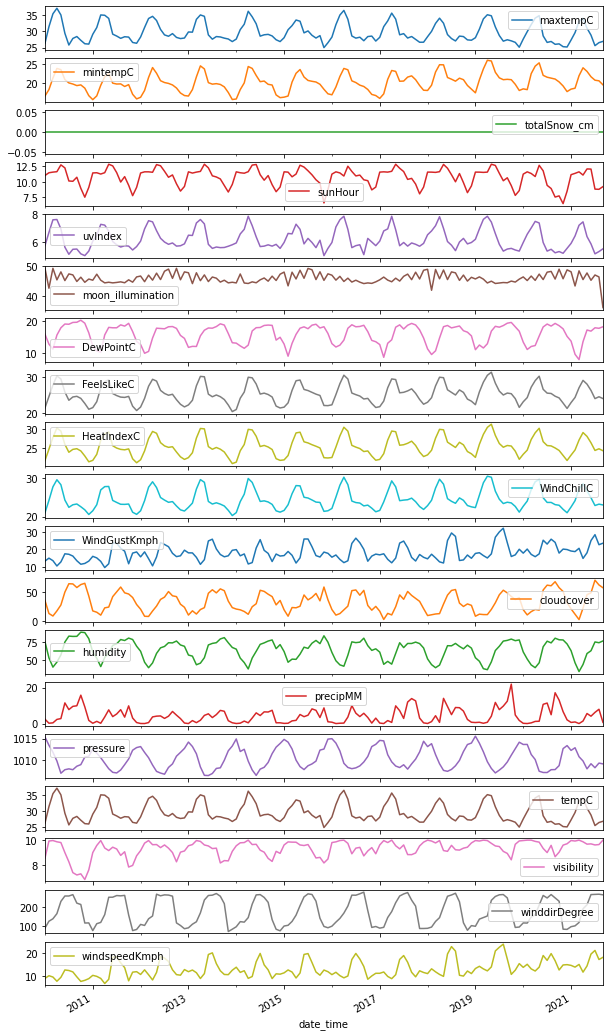

In [7]:
import datetime as dt

def weather_clean(df):
    return df.set_index('date_time', drop=True).groupby(pd.Grouper(freq='M')).mean()
df1 = weather_clean(df)
df1.plot(figsize=(10,20),subplots=True, legend='best');

In [8]:
df_aqi.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,1855.000000,1636.000000,1909.000000,1909.000000,1907.000000,1720.000000,1900.000000,1909.000000,1783.000000,1678.000000,1824.000000,0.0,1910.000000
mean,35.871628,83.404444,9.361409,28.308753,19.741274,22.232523,1.669216,5.255631,32.858054,1.759660,4.288333,NaN,94.318325
std,22.100592,38.070544,7.213873,13.401420,15.327229,12.827410,3.634505,2.522250,18.464787,4.030258,15.588196,NaN,39.914934
min,1.720000,8.220000,0.460000,3.000000,0.000000,0.150000,0.000000,0.730000,1.830000,0.000000,0.000000,NaN,20.000000
25%,21.305000,56.462500,5.020000,18.990000,7.720000,14.090000,0.720000,3.740000,17.860000,0.430000,1.140000,NaN,67.000000
50%,30.970000,77.485000,7.540000,27.400000,19.430000,20.000000,0.915000,4.990000,30.460000,0.795000,1.750000,NaN,86.000000
75%,44.265000,103.937500,11.730000,34.640000,28.825000,26.532500,1.140000,6.360000,45.580000,1.470000,2.900000,NaN,111.000000
max,313.590000,351.510000,95.190000,142.350000,147.060000,120.070000,48.070000,29.110000,157.200000,47.260000,411.520000,NaN,352.000000


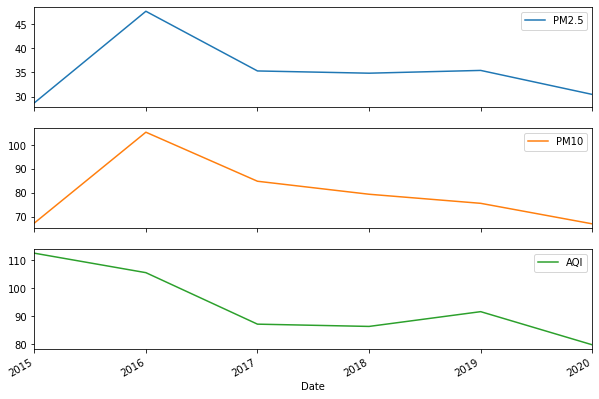

In [171]:
def aqi_clean(df_aqi):
    df_aqi['Date'] = df_aqi['Date'].apply(lambda x: pd.to_datetime(x))
    return df_aqi[['Date','AQI']].set_index('Date', drop=True)
df2 = aqi_clean(df_aqi).groupby(pd.Grouper(freq='1W')).mean()
df2.plot(figsize=(10,7));

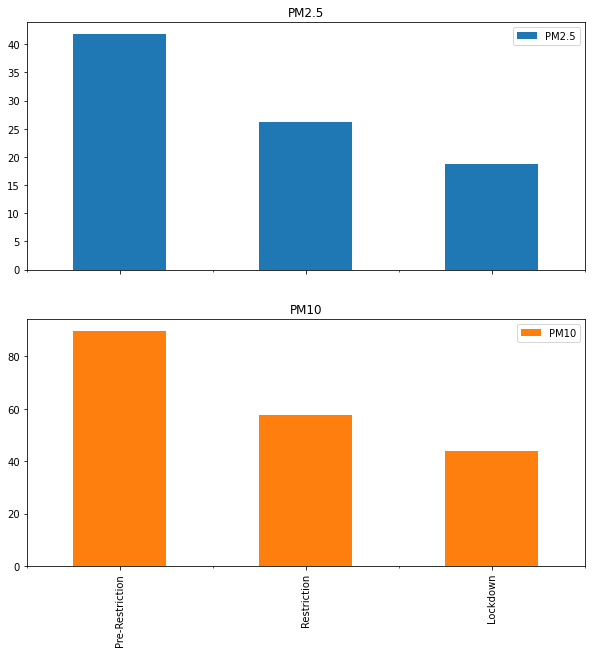

In [179]:
df_compare = pd.read_csv('data/averages.csv')
df_compare.set_index('Index', inplace=True)
df_compare.T.plot(figsize=(10,10),kind='bar', subplots=True);

In [119]:
df_combined = df1[df1.index.isin(df2.index)]
df_combined['AQI'] = df2.AQI

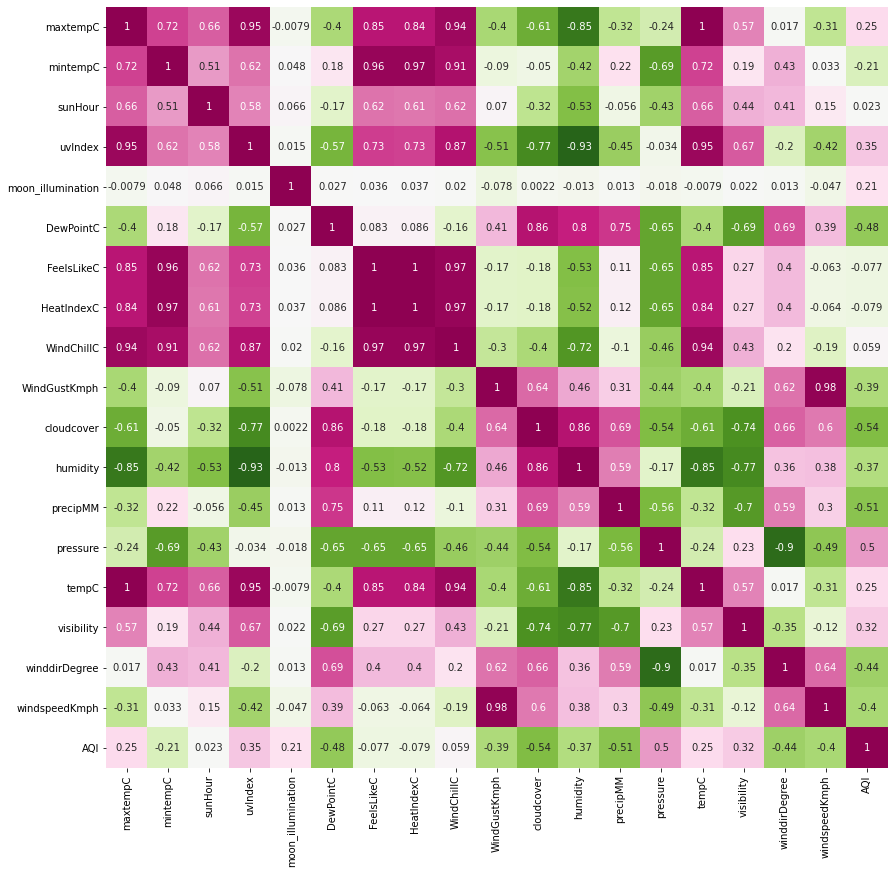

In [194]:
plt.subplots(figsize=(14,14))
sns.heatmap(df_combined.drop('totalSnow_cm',axis=1).corr(), annot=True, cmap='PiYG_r', cbar=False);

### Splitting our dataset to pre and post lockdown data.

While the first official lockdown started on 24th May 2020, the Karnataka State government had started taking actions to curb up travel since 9th March 2020, which was the day it was announced that schools would be closing down, soon after which all public gathering places were shut. Due to this, and the limited nature of our post-May data, we will be using March 10th as the cutoff date, as that was the day the first travel restriction came into effect.

We will also be creating a scaled copy of the data because it helps with the computational load while training the neural network.

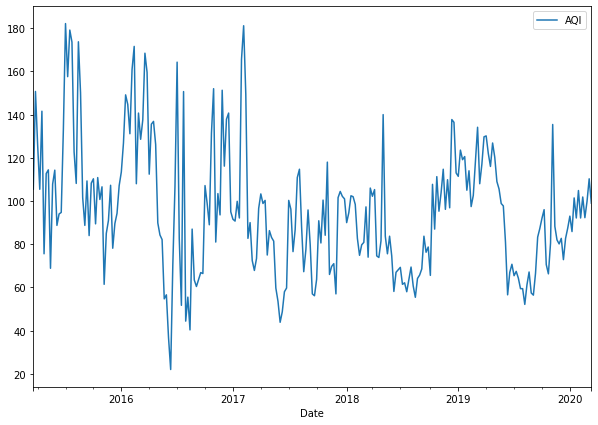

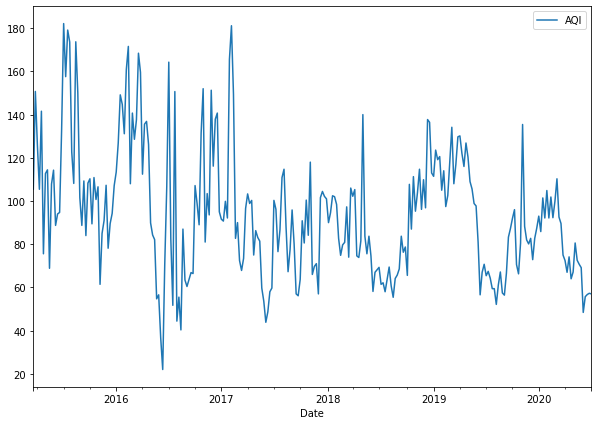

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1,1))
lockdown = dt.datetime(2020, 3, 10)
 
aqi = df_aqi.copy()

aqi_full = aqi_clean(df_aqi).groupby(pd.Grouper(freq='1W')).mean()
aqi_full_scaled = scaler.fit_transform(aqi_full.values)

df_aqi_pre = aqi[aqi['Date']<lockdown]
aqi_pre = aqi_clean(df_aqi_pre).groupby(pd.Grouper(freq='1W')).mean()

aqi_pre.plot(figsize=(10,7))
aqi_full.plot(figsize=(10,7));

#### Running a one-way ANOVA to test significant change since the first lockdown:

In [139]:
anova = aqi_full.copy()
anova['status'] = np.where(anova.index < lockdown, 'Pre', 'Post')
anova.reset_index(drop=True, inplace=True)

p-value of the ANOVA test: 0.0003


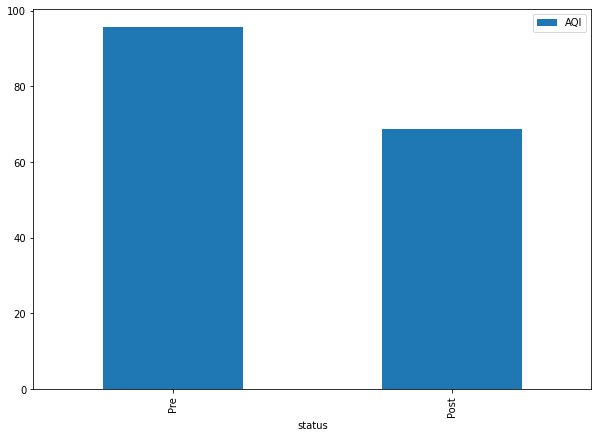

In [161]:
import scipy.stats as st

group = ['Pre','Post']
data = {item: anova['AQI'][anova.status == item] for item in group}
F, p = st.f_oneway(data['Pre'], data['Post'])
print('p-value of the ANOVA test:',round(p,4))
anova.groupby('status').mean().sort_values('AQI', ascending=False).plot(kind='bar', figsize=(10,7));

#### Bengaluru Wards AQI Analysis:

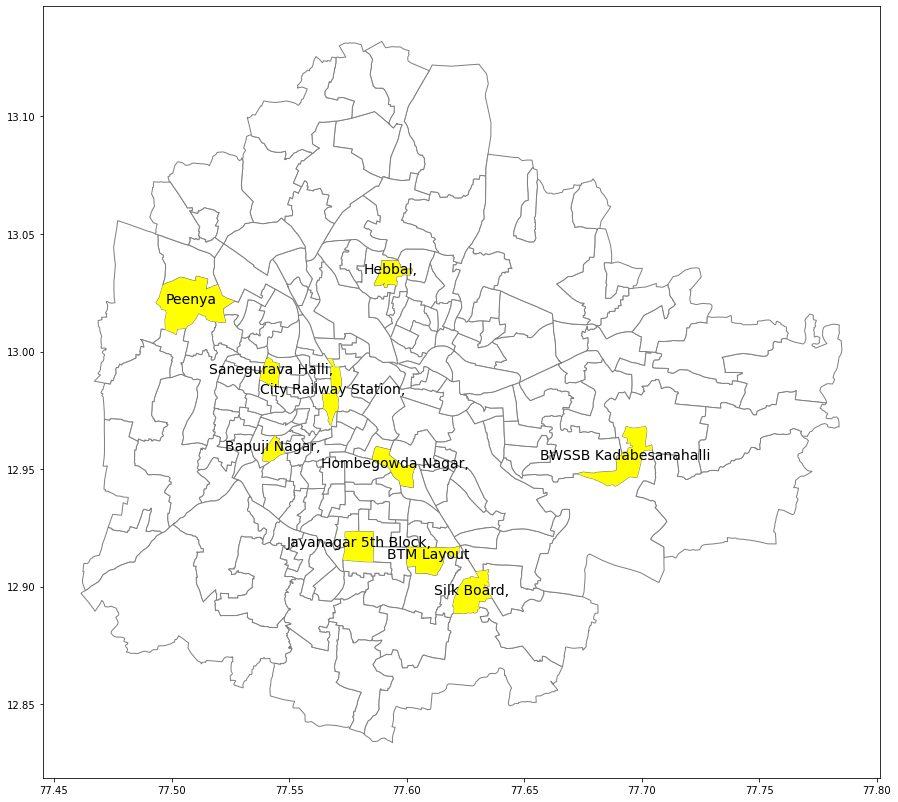

In [121]:
from shapely import wkt


bangalore = gpd.read_file('bangalore/bangalore/GIS/BBMP_Wards_2011_region.json')
ax = bangalore.plot(figsize=(15,15),color='white', edgecolor='grey')
points = pd.read_csv('data/stations.csv')
points['geometry'] = points['geometry'].apply(wkt.loads)
gpoints = gpd.GeoDataFrame(points, crs='epsg:4326')
gpoints['StationName'] = gpoints['StationName'].apply(lambda x: x[:-18])
plt1 = gpoints.plot(color='yellow', ax=ax)

gpoints.apply(lambda x: plt1.annotate(text=x.StationName, xy=x.geometry.centroid.coords[0], ha='center', size=14), axis=1);

The above (yellow) wards are the ones where AQI is measured in the dataset.

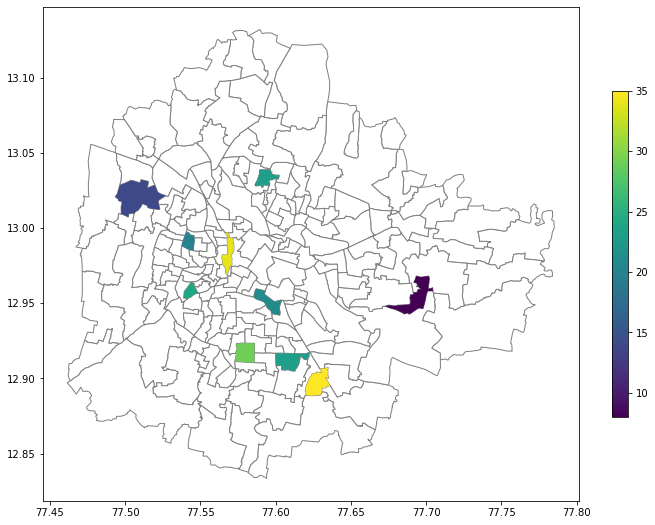

In [69]:
station = pd.read_csv('data/station_day.csv')
aqi_station = station[(station['StationId'].str.contains('KA'))&(station['AQI'].notnull())][['StationId','Date','AQI']]
aqi_station = aqi_station.merge(points[['StationId','StationName','geometry']],on=['StationId'])
aqi_min = aqi_station.loc[aqi_station.groupby('StationId')['AQI'].idxmin()]
st_data = gpd.GeoDataFrame(aqi_min, crs='epsg:4326')
ax = bangalore.plot(figsize=(12,12),color='white', edgecolor='grey')
st_data.plot(column='AQI', ax=ax, legend=True, legend_kwds={'shrink': 0.3});

When observing the minimum values of AQI, we see that the infamous Silk Board has the highest minimum while Marathalli has the lowest.

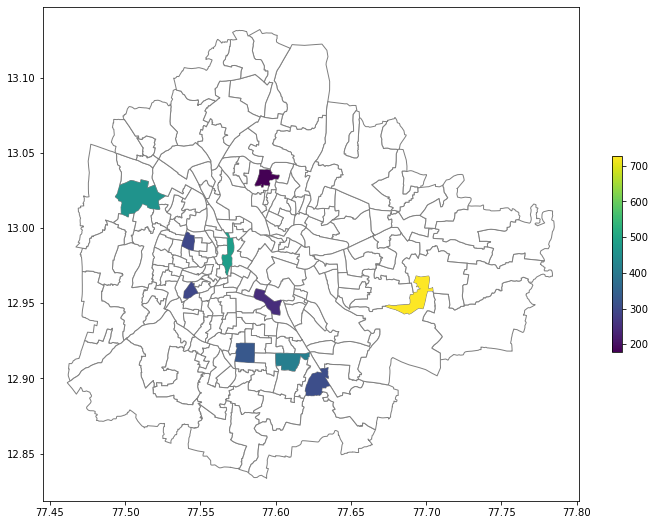

In [70]:
aqi_max = aqi_station.loc[aqi_station.groupby('StationId')['AQI'].idxmax()]
st_data = gpd.GeoDataFrame(aqi_max, crs='epsg:4326')
ax = bangalore.plot(figsize=(12,12),color='white', edgecolor='grey')
st_data.plot(column='AQI', ax=ax, legend=True, legend_kwds={'shrink': 0.3});

The maximum values show a different trend as the developing space fo Marathalli showcases the highest peak, whereas Hebbal appears to be much better off.

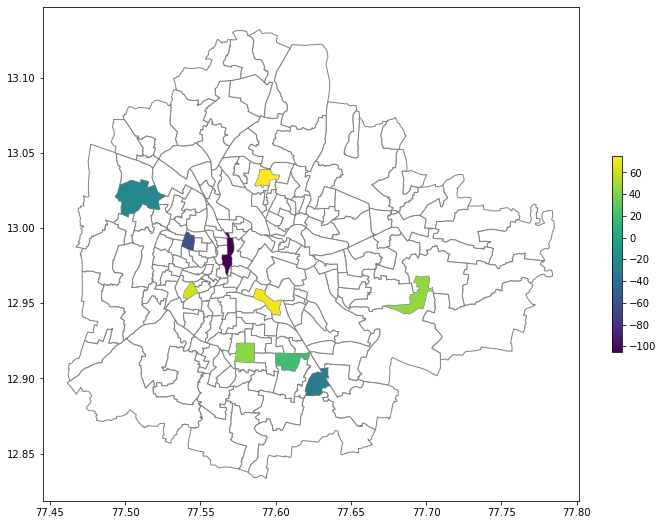

In [115]:
aqi_station['Date'] = pd.to_datetime(aqi_station.Date)
aqi_change = aqi_station[aqi_station['Date']<lockdown]
aqi_change = aqi_change.groupby(['StationId'])['AQI'].agg(['first','last']).reset_index()
aqi_change['diff'] = aqi_change['last'] - aqi_change['first']
aqi_change = aqi_change.merge(points[['StationId','geometry']],on=['StationId'])
st_data = gpd.GeoDataFrame(aqi_change, crs='epsg:4326')
ax = bangalore.plot(figsize=(12,12),color='white', edgecolor='grey')
st_data.plot(column='diff', ax=ax, legend=True, legend_kwds={'shrink': 0.3});

Finally, we look at the change in AQI over the course of the dataset (2015-2020), we see that all the values are in the negatives which means that from day 1 to the last, every ward has seen an improvement in the Air Quality. The air quality in Jaynagar has improved the least, whereas City Railway Station has seen an incredible improvement of close to 180 AQI.

#### Framing the problem:

The high-level steps to be taken here are:
1. Train models for each set of data.
2. Make predictions on the pre-covid data until present date.
3. Make predictions on the full data.
4. Plot them together.

#### Making Predictions using Deep Learning (LSTMs):

In [17]:
aqi_pre_train = aqi_pre.iloc[:round(len(aqi_pre)*0.7)]
aqi_pre_test = aqi_pre.iloc[round(len(aqi_pre)*0.7):]

To make predictions using a Keras LSTM Neural Network, we will have to transform the forecasting problem into a supervised learning problem, where the input will be a set of 'n' previous values and the label will be the present value of AQI. To do this, we will use the TimeSeriesGenerator function provided by Keras which takes 'n' as a parameter (length).

To determine the value of n, we will train dummy models for n-values ranging from 2-10, and select the one with the lowest evaluation metric (RMSE), and that value will then be used to train the actual model to make the forecast. 

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator

temp_train1 = scaler.transform(aqi_pre_train)
model_score = dict()

for i in range(2,11):
    print(i, '- Starting.')
    features= 1
    loss = list()
    generator = TimeseriesGenerator(temp_train1, temp_train1, length=i, batch_size=1)
    
    model = Sequential()
    model.add(LSTM(150, batch_input_shape=(1, i, features),  stateful=True))
    # input_shape=(n, features),
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')

    for _ in range(250):
        model.fit(generator, epochs=1, shuffle=False, verbose=False)
        loss.append(model.history.history['loss'])
        model.reset_states()


    lstm_predictions_scaled = list()
    batch = temp_train1[-i:]
    current_batch = batch.reshape((1, i, features))

    for _ in range(len(aqi_pre_test)):   
        lstm_pred = model.predict(current_batch)[0]
        lstm_predictions_scaled.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

    score = np.sqrt(mean_squared_error(aqi_pre_test['AQI'],lstm_predictions))
    model_score[i] = score
    print(i, score)

2 - Starting.
2 32.7416120060329
3 - Starting.
3 32.00392682484022
4 - Starting.
4 36.684313724294995
5 - Starting.
5 30.452144988227573
6 - Starting.
6 44.628194666094004
7 - Starting.
7 30.408251147399117
8 - Starting.
8 24.72056972972658
9 - Starting.
9 42.58960271263611
10 - Starting.
10 22.167881459383793


In [55]:
a = 100000
b = 1
for i in model_score:
    if model_score[i] < a:
        a = model_score[i]
        b = i

print('Best n:',b)
print('RMSE:',a)

Best n: 10
RMSE: 22.167881459383793


In [20]:
n = deepcopy(b)
features= 1

model = Sequential()
model.add(LSTM(150, batch_input_shape=(1, n, features),  stateful=True))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
loss = list()
generator = TimeseriesGenerator(temp_train1, temp_train1, length=n, batch_size=1)


for _ in range(2000):
    model.fit(generator, epochs=1, shuffle=False, verbose=False)
    loss.append(model.history.history['loss'])
    model.reset_states()


lstm_predictions_scaled = list()
batch = temp_train1[-n:]
current_batch = batch.reshape((1, n, features))

for _ in range(len(aqi_pre_test)):   
    lstm_pred = model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

[0.00023030351439956576]


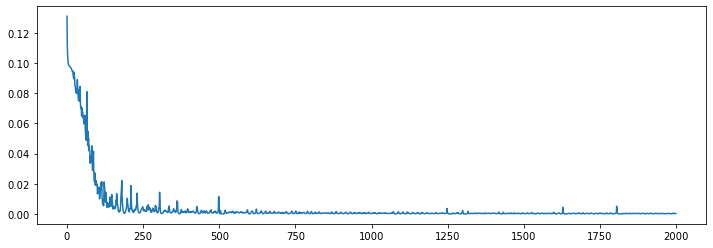

In [21]:
loss_df = pd.DataFrame(loss, columns=['loss'])
plt.figure(figsize=(12,4))
plt.plot(range(len(loss_df)),loss_df)
print(loss[-1]);

In [28]:
lstm_predictions_scaled = list()

batch = temp_train1[-n:]
current_batch = batch.reshape((1, n, features))

for i in range(len(aqi_pre_test)):   
    lstm_pred = model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [29]:
aqi_pre_test['predictions'] = lstm_predictions
aqi_pre_test['error'] = (aqi_pre_test.AQI - aqi_pre_test.predictions)**2
print('Test RMSE:', round(np.sqrt(aqi_pre_test.error.mean()),2))

Test RMSE: 26.11


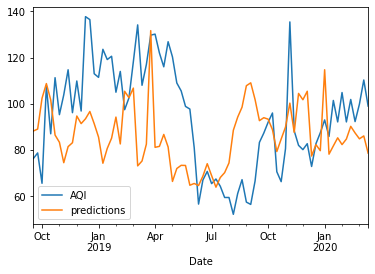

In [30]:
aqi_pre_test[['AQI','predictions']].plot();

In [25]:
aqi_pre_test

,AQI,predictions,error
Date,,,
2018-09-23,76.285714,87.620804,128.484255
2018-09-30,78.714286,89.865998,124.360680
2018-10-07,65.571429,103.854341,1465.581346
2018-10-14,107.714286,109.211946,2.242985
2018-10-21,87.000000,101.098752,198.774819
...,...,...,...
2020-02-16,101.857143,81.285166,423.206223
2020-02-23,92.285714,86.989681,28.047969
2020-03-01,99.857143,90.131138,94.595180


#### Making projections till current date:

In [26]:
daterange = pd.date_range('2020-03-22','2021-09-26' , freq='1W')
projections = pd.DataFrame(index=daterange)

In [39]:
lstm_predictions_pre_s = list()
lstm_predictions_post_s = list()

batch_pre = scaler.transform(aqi_pre_test[["AQI"]])[-n:]
current_batch_pre = batch_pre.reshape((1, n, features))

for i in range(len(daterange)):   
    lstm_pred = model.predict(current_batch_pre)[0]
    lstm_predictions_pre_s.append(lstm_pred)
    current_batch_pre = np.append(current_batch_pre[:,1:,:],[[lstm_pred]],axis=1)
    
lstm_predictions_pre = scaler.inverse_transform(lstm_predictions_pre_s)


batch_post = scaler.transform(aqi_full.values)[-n:]
current_batch_post = batch_post.reshape((1, n, features))

for i in range(len(daterange)):   
    lstm_pred = model.predict(current_batch_post)[0]
    lstm_predictions_post_s.append(lstm_pred)
    current_batch_post = np.append(current_batch_post[:,1:,:],[[lstm_pred]],axis=1)
    
lstm_predictions_post = scaler.inverse_transform(lstm_predictions_post_s)

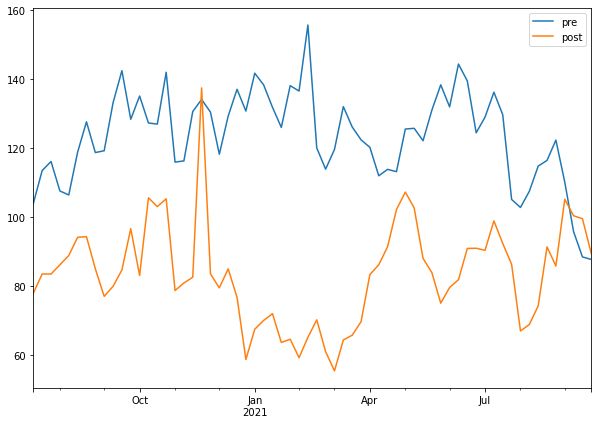

In [192]:
projections['pre'] = lstm_predictions_pre
projections['post'] = lstm_predictions_post

projections[~projections.index.isin(aqi_full.index)].plot(figsize=(10,7));

In [56]:
projections.describe()

,pre,post
count,80.000000,80.000000
mean,118.291243,83.411789
std,16.342991,14.176387
min,74.489164,55.481191
25%,106.370003,73.380246
50%,119.464077,83.584743
75%,130.689090,91.124846
max,155.729663,137.494693


We see here that taking the data post lockdown into consideration, we get projections that are significantly lower than those before the pandemic.

The mean is ~35 AQI points lesser, so is the median, and as the table above demonstrates, by almost every measure, the lockdown improved the projections for air quality in Bangalore.

In [42]:
projections.to_csv('data/projections.csv')